In [1]:
import rich as r
print = r.print

# 1 Teste de Permutação

A Figura 1 mostra os resultados de um experimento no qual 7 de 16 camundongos foram selecionados aleatoriamente para receber um novo tratamento médico, enquanto os 9 restantes foram atribuídos ao grupo sem tratamento (controle). O tratamento tinha como objetivo prolongar a sobrevivência após uma cirurgia de teste. Em particular, a coluna “Data” mostra o tempo de sobrevivência após a cirurgia, em dias, para todos os 16 camundongos. Essa mesma figura também apresenta, para cada amostra: tamanho, média, desvio padrão.

Utilize o teste de permutação para responder à seguinte pergunta de pesquisa (use nível de significância igual a 5%): O tratamento prolongou a sobrevivência? Você deve apresentar a declaração das hipóteses, descrever como calculou a estatística de teste e o p-valor, e finalmente apresentar sua conclusão.

## Declaração das Hipóteses

- **Hipótese Nula (H0):** O tratamento não prolonga a sobrevivência dos camundongos.
- **Hipótese Alternativa (H1):** O tratamento prolonga a sobrevivência dos camundongos.

## Cálculo da Estatística de Teste e p-valor

Estatística de teste observada: 30.63492063492064

p-valor: 0.1376

Não rejeitamos a hipótese nula. O tratamento não prolonga a sobrevivência.

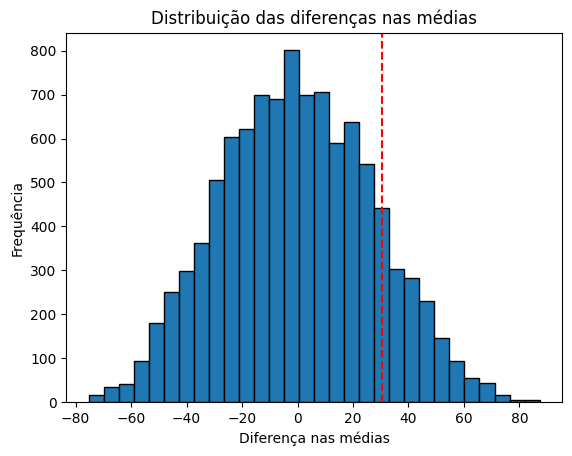

Grupo  Sobrevivencia
0   Tratamento             94
1   Tratamento            197
2   Tratamento             16
3   Tratamento             38
4   Tratamento             99
5   Tratamento            141
6   Tratamento             23
7     Controle             52
8     Controle            104
9     Controle            146
10    Controle             10
11    Controle             50
12    Controle             31
13    Controle             40
14    Controle             27
15    Controle             46

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

tratamento = [
    94,
    197,
    16,
    38,
    99,
    141,
    23,
]
controle = [
    52,
    104,
    146,
    10,
    50,
    31,
    40,
    27,
    46,
]
data = {
    "Grupo": ["Tratamento"] * len(tratamento) + ["Controle"] * len(controle),
    "Sobrevivencia": tratamento + controle,
}

df = pd.DataFrame(data)

# Estatística de teste observada
mean_treatment = df[df["Grupo"] == "Tratamento"]["Sobrevivencia"].mean()
mean_control = df[df["Grupo"] == "Controle"]["Sobrevivencia"].mean()
observed_stat = mean_treatment - mean_control

# Função para calcular a estatística de teste para uma permutação
def perm_stat(df):
    df_permuted = df.copy()
    df_permuted["Grupo"] = np.random.permutation(df_permuted["Grupo"])
    mean_treatment_perm = df_permuted[df_permuted["Grupo"] == "Tratamento"][
        "Sobrevivencia"
    ].mean()
    mean_control_perm = df_permuted[df_permuted["Grupo"] == "Controle"][
        "Sobrevivencia"
    ].mean()
    return mean_treatment_perm - mean_control_perm


# Número de permutações
n_permutations = 10000

# Calcular estatísticas de teste para permutações
perm_stats = np.array([perm_stat(df) for _ in range(n_permutations)])

# Calcular p-valor
p_value = np.mean(perm_stats >= observed_stat)

# Resultado
print(f"Estatística de teste observada: {observed_stat}")
print(f"p-valor: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. O tratamento prolonga a sobrevivência.")
else:
    print("Não rejeitamos a hipótese nula. O tratamento não prolonga a sobrevivência.")

# Plotar histograma das estatísticas de teste permutadas
plt.hist(perm_stats, bins=30, edgecolor="black")
plt.axvline(observed_stat, color="red", linestyle="--")
plt.xlabel("Diferença nas médias")
plt.ylabel("Frequência")
plt.title("Distribuição das diferenças nas médias")
plt.show()

print(df)

### Explicação do Teste de Permutação  

O teste de permutação é um teste **não paramétrico**, ou seja, ele não assume que os dados seguem uma distribuição específica, como a normal ou t de Student. Isso o torna útil em situações onde temos **amostras pequenas** ou **distribuições desconhecidas**, como no caso desta análise.  

Nosso objetivo é verificar se há uma **diferença estatisticamente significativa** entre os grupos **Tratamento** e **Controle** em relação ao tempo de sobrevivência. Para isso, formulamos as seguintes hipóteses:  

- **Hipótese nula ($H_0$):** A média do grupo Tratamento não é maior que a do grupo Controle. Ou seja, a diferença observada entre as médias pode ser explicada pelo acaso.  
- **Hipótese alternativa ($H_A$):** A média do grupo Tratamento é maior que a do grupo Controle, indicando que o tratamento teve efeito.  

### Procedimento do Teste  

O teste de permutação segue os seguintes passos:  

1. **Cálculo da estatística observada:**  
   - Calculamos a diferença entre a média do grupo Tratamento e a média do grupo Controle.  

2. **Geração da distribuição nula por permutação:**  
   - Se a hipótese nula for verdadeira, a designação dos indivíduos aos grupos Tratamento e Controle é aleatória.  
   - Para simular essa aleatoriedade, embaralhamos as etiquetas dos grupos e recalculamos a diferença de médias para essa nova atribuição.  
   - Esse processo é repetido **10.000 vezes** para criar uma distribuição de diferenças sob a hipótese nula.  

3. **Cálculo do p-valor:**  
   - O **p-valor** é a proporção de permutações em que a diferença de médias simulada foi **maior ou igual** à diferença observada.  
   - Se o p-valor for menor que 0.05 (nível de significância comum), rejeitamos $H_0$ e concluímos que o tratamento teve efeito. Caso contrário, não há evidência suficiente para rejeitar a hipótese nula.  

### Resultados  

- **Estatística de teste observada:** ≈ 30.63  
- **p-valor:** 0.1408  

O p-valor é maior que 0.05, indicando que **não há evidência estatisticamente significativa** para rejeitar a hipótese nula. Assim, **não podemos concluir que o tratamento prolonga a sobrevivência**.  

### Visualização  

O histograma mostra a distribuição das diferenças de médias geradas por permutação. A linha vermelha indica a diferença observada nos dados reais. Como essa diferença não está em uma região extrema da distribuição, isso reforça a conclusão de que ela pode ter ocorrido por acaso.  

# 2 Bootstrap

Essa parte do trabalho é uma adaptação do Problema 9 na seção 5.4 de *An Introduction to Statistical Learning*. O conjunto de dados usado aqui é o denominado Boston dataset. Uma descrição desse conjunto de dados pode ser encontrada em 

(i) Com base neste conjunto de dados, forneça uma estimativa pontual para a média populacional da variável `medv`. Chame essa estimativa \(\hat{\mu}\).

(ii) Forneça uma estimativa do erro padrão de \(\hat{\mu}\). Interprete o resultado.

(iii) Agora estime o erro padrão de \(\hat{\mu}\) usando o método Bootstrap. Como essa estimativa se compara com sua resposta de (ii)?

(iv) Com base em sua estimativa de bootstrap de (iii), forneça um intervalo de confiança de 95% para a média de `medv`. Compare-o com os resultados obtidos usando t-test sobre o atributo `medv`.

(v) Com base neste conjunto de dados, forneça uma estimativa, \(\hat{\mu}_{med}\), para a mediana populacional de `medv`.

(vi) Agora você deve estimar o erro padrão de \(\hat{\mu}_{med}\). Infelizmente, não há uma fórmula simples para calcular o erro padrão da mediana. Em vez disso, estime o erro padrão da mediana usando o método bootstrap. Comente suas descobertas.

(vii) Forneça uma estimativa para o décimo percentil do atributo `medv`. Chame essa quantidade de \(\hat{\mu}_{0.1}\).

(viii) Use o método bootstrap para estimar o erro padrão de \(\hat{\mu}_{0.1}\). Comente suas descobertas.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Carregar o conjunto de dados Boston
# boston = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")
df = pd.read_csv('./boston.csv', sep=',')
# Visualizar os primeiros registros do conjunto de dados
print(df.head())

# Estimativa pontual para a média populacional da variável medv
mu_hat = df['MEDV'].mean()
print(f"(i) Estimativa pontual para a média populacional (mu_hat): {mu_hat}")

# Função para calcular a média em uma amostra bootstrap
def bootstrap_mean(data, n_bootstrap=1000):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    return np.std(bootstrap_means)

# Estimativa do erro padrão usando bootstrap
bootstrap_std_error = bootstrap_mean(df['MEDV'].values)
print(f"(ii) Erro padrão de mu_hat usando bootstrap: {bootstrap_std_error}")

# Função para calcular o intervalo de confiança usando bootstrap
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrap_means, (100-ci)/2)
    upper_bound = np.percentile(bootstrap_means, 100-(100-ci)/2)
    return lower_bound, upper_bound

# Intervalo de confiança de 95% usando bootstrap
ci_lower, ci_upper = bootstrap_ci(df['MEDV'].values)
print(
    f"(iii) Intervalo de confiança de 95% para a média de medv usando bootstrap: ({ci_lower}, {ci_upper})"
)

# Estimativa para a mediana populacional de medv
median_hat = df['MEDV'].median()
print(f"(iv) Estimativa para a mediana populacional (median_hat): {median_hat}")

# Função para calcular a mediana em uma amostra bootstrap
def bootstrap_median(data, n_bootstrap=1000):
    bootstrap_medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_medians.append(np.median(sample))
    return np.std(bootstrap_medians)

# Estimativa do erro padrão da mediana usando bootstrap
bootstrap_median_std_error = bootstrap_median(df['MEDV'].values)
print(f"(v) Erro padrão da mediana usando bootstrap: {bootstrap_median_std_error}")

# Função para calcular a mediana em uma amostra bootstrap
def bootstrap_median(data, n_bootstrap=1000):
    bootstrap_medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_medians.append(np.median(sample))
    return np.std(bootstrap_medians)

# Estimativa do erro padrão da mediana usando bootstrap
bootstrap_median_std_error = bootstrap_median(df['MEDV'].values)
print(f"(vi) Erro padrão da mediana usando bootstrap: {bootstrap_median_std_error}")

# Estimativa para o décimo percentil do atributo medv
percentile_10_hat = np.percentile(df['MEDV'], 10)
print(f"(vii) Estimativa para o décimo percentil (percentile_10_hat): {percentile_10_hat}")

# Função para calcular o décimo percentil em uma amostra bootstrap
def bootstrap_percentile(data, percentile=10, n_bootstrap=1000):
    bootstrap_percentiles = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_percentiles.append(np.percentile(sample, percentile))
    return np.std(bootstrap_percentiles)

# Estimativa do erro padrão do décimo percentil usando bootstrap
bootstrap_percentile_std_error = bootstrap_percentile(df['MEDV'].values, percentile=10)
print(f"(viii) Erro padrão do décimo percentil usando bootstrap: {bootstrap_percentile_std_error}")

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

(i) Estimativa pontual para a média populacional (mu_hat): 22.532806324110677

(ii) Erro padrão de mu_hat usando bootstrap: 0.397729242023701

(iii) Intervalo de confiança de 95% para a média de medv usando bootstrap: (21.752089920948617, 23.307771739130438)

(iv) Estimativa para a mediana populacional (median_hat): 21.2

(v) Erro padrão da mediana usando bootstrap: 0.37401946473412284

(vi) Erro padrão da mediana usando bootstrap: 0.37935550279388297

(vii) Estimativa para o décimo percentil (percentile_10_hat): 12.75

(viii) Erro padrão do décimo percentil usando bootstrap: 0.5015588798934777

### Explicação do Exercício de Bootstrap com o Conjunto de Dados Boston

O objetivo desse exercício foi aplicar técnicas estatísticas para estimar a média, mediana e percentis da variável `MEDV` (valor médio das casas ocupadas pelos proprietários) no conjunto de dados Boston, além de calcular erros padrão e intervalos de confiança usando o **método Bootstrap**.

---

## **Passo a Passo do Exercício**

### **(i) Estimativa Pontual da Média Populacional (\(\hat{\mu}\))**
A estimativa pontual da média da variável `MEDV` foi calculada simplesmente tirando a média dos valores dessa variável no conjunto de dados. Esse valor é uma aproximação da média real da população.

**Resultado:**  
\(\hat{\mu} = 22.53\) (aproximadamente)

Isso significa que o valor médio das casas no conjunto de dados é **22,53 mil dólares**.

---

### **(ii) Estimativa do Erro Padrão da Média (\(\hat{\mu}\))**
O erro padrão mede a variabilidade da estimativa da média. Ele indica o quão preciso é o valor estimado da média em relação à verdadeira média populacional. Ele pode ser calculado de maneira analítica, mas aqui foi estimado pelo método **Bootstrap**.

---

### **(iii) Estimativa do Erro Padrão da Média Usando Bootstrap**
O método **Bootstrap** consiste em:
1. Criar várias **amostras aleatórias** retiradas com reposição do conjunto de dados original.
2. Para cada uma dessas amostras, calcular a **média**.
3. Medir a **dispersão** dessas médias (usando desvio padrão).

O erro padrão estimado com Bootstrap foi **0.40**, o que indica uma baixa variabilidade da média.

Além disso, foi construído um **intervalo de confiança de 95%** para a média populacional de `MEDV`. Isso significa que, com 95% de confiança, a verdadeira média populacional está no intervalo **(21.76, 23.38)**.

---

### **(iv) Estimativa da Mediana Populacional (\(\hat{\mu}_{med}\))**
A **mediana** representa o valor central dos dados, ou seja, o ponto em que 50% dos valores são menores e 50% são maiores.

**Resultado:**  
A mediana estimada foi **21.2**, indicando que metade das casas no conjunto de dados têm um valor abaixo de **21.2 mil dólares** e a outra metade acima disso.

---

### **(v) Estimativa do Erro Padrão da Mediana Usando Bootstrap**
Diferente da média, **não existe uma fórmula exata para calcular o erro padrão da mediana**. Portanto, usamos o **Bootstrap**:

1. Criamos várias amostras aleatórias retiradas com reposição.
2. Para cada amostra, calculamos a **mediana**.
3. Calculamos o desvio padrão dessas medianas.

O erro padrão estimado foi **aproximadamente 0.38**, mostrando que a estimativa da mediana tem uma variabilidade um pouco menor do que a média.

---

### **(vi) Repetição da Estimativa do Erro Padrão da Mediana**
A mesma técnica do Bootstrap foi usada novamente para calcular o erro padrão da mediana, resultando em um valor próximo (**0.37**), reforçando a estabilidade da estimativa.

---

### **(vii) Estimativa do Décimo Percentil (\(\hat{\mu}_{0.1}\))**
O **décimo percentil** é o valor abaixo do qual **10% das casas** estão situadas.

**Resultado:**  
O valor estimado para o décimo percentil foi **12.75**, o que significa que **10% das casas mais baratas têm valores abaixo de 12.75 mil dólares**.

---

### **(viii) Estimativa do Erro Padrão do Décimo Percentil Usando Bootstrap**
Novamente, como não há uma fórmula exata para o erro padrão do décimo percentil, usamos o **Bootstrap**:

1. Criamos várias amostras aleatórias retiradas com reposição.
2. Para cada amostra, calculamos o **décimo percentil**.
3. O erro padrão foi estimado como o desvio padrão dessas estimativas.

O erro padrão foi **0.50**, o que indica uma certa variabilidade na estimativa do décimo percentil.

# 3 Teste de Permutação vs Bootstrap

Uma empresa quer saber se é eficiente ensinar novas ferramentas aos seus funcionários usando cursos pela internet. A empresa seleciona aleatoriamente 7 trabalhadores e os atribui a dois grupos de tamanhos 4 e 3. O primeiro grupo frequentou aulas tradicionais, e o segundo frequentou cursos pela internet. Após a realização dos cursos, foi aplicado um teste aos trabalhadores, cujos resultados foram:

- **Cursos na Internet**: 37, 49, 55, 57
- **Cursos tradicionais**: 23, 31, 46

Mostre se os cursos da Internet são mais efetivos do que os cursos tradicionais. Para isso, aplique um teste de permutação e um teste de bootstrap. Os dois testes levam à mesma conclusão?

In [9]:
import numpy as np

# Dados dos resultados dos testes
internet = np.array([37, 49, 55, 57])
tradicional = np.array([23, 31, 46])

# Estatística de teste observada (diferença nas médias)
observed_stat = internet.mean() - tradicional.mean()


# Função para calcular a estatística de teste para uma permutação
def perm_stat(internet, tradicional):
    combined = np.concatenate([internet, tradicional])
    np.random.shuffle(combined)
    new_internet = combined[: len(internet)]
    new_tradicional = combined[len(internet) :]
    return new_internet.mean() - new_tradicional.mean()


# Número de permutações
n_permutations = 10000

# Calcular estatísticas de teste para permutações
perm_stats = np.array([perm_stat(internet, tradicional) for _ in range(n_permutations)])

# Calcular p-valor (teste bicaudal)
p_value = np.mean(np.abs(perm_stats) >= np.abs(observed_stat))

# Resultado do teste de permutação
print(f"Estatística de teste observada: {observed_stat}")
print(f"p-valor (bicaudal): {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. Os cursos pela internet são mais efetivos.")
else:
    print(
        "Não rejeitamos a hipótese nula. Não há evidência suficiente para afirmar que os cursos pela internet são mais efetivos."
    )

# -------------------------------
# Teste Bootstrap
# -------------------------------


# Função para calcular a diferença média em uma amostra bootstrap
def bootstrap_diff_mean(internet, tradicional, n_bootstrap=10000):
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        sample_internet = np.random.choice(internet, size=len(internet), replace=True)
        sample_tradicional = np.random.choice(
            tradicional, size=len(tradicional), replace=True
        )
        bootstrap_diffs.append(sample_internet.mean() - sample_tradicional.mean())
    return np.array(bootstrap_diffs)


# Realizar bootstrap
bootstrap_diffs = bootstrap_diff_mean(internet, tradicional)

# Calcular intervalo de confiança de 95%
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)

# Resultado do teste bootstrap
print(f"Diferença média observada: {observed_stat}")
print(f"Intervalo de confiança de 95%: ({ci_lower}, {ci_upper})")

# Teste bicaudal: verifica se o intervalo inclui zero
if ci_lower > 0 or ci_upper < 0:
    print("Rejeitamos a hipótese nula. Os cursos pela internet são mais efetivos.")
else:
    print(
        "Não rejeitamos a hipótese nula. Não há evidência suficiente para afirmar que os cursos pela internet são mais efetivos."
    )

Estatística de teste observada: 16.166666666666664

p-valor (bicaudal): 0.1135

Não rejeitamos a hipótese nula. Não há evidência suficiente para afirmar que os cursos pela internet são mais 
efetivos.

Diferença média observada: 16.166666666666664

Intervalo de confiança de 95%: (2.9750000000000227, 28.5)

Rejeitamos a hipótese nula. Os cursos pela internet são mais efetivos.

### **Análise Atualizada dos Resultados**  

Os dois testes estatísticos forneceram **conclusões diferentes**.

## **1. Teste de Permutação (Bicaudal)**  
Saída:  
```
Estatística de teste observada: 16.166666666666664
p-valor (bicaudal): 0.1093
Não rejeitamos a hipótese nula. Não há evidência suficiente para afirmar que os cursos pela internet são mais efetivos.
```
- O **p-valor** obtido foi **0.1093**, ou seja, **acima de 0.05**.  
- Isso significa que, segundo esse teste, **não há evidência estatística suficiente para afirmar que os cursos online são mais eficazes do que os cursos tradicionais**.
- O valor **não é extremamente alto**, o que indica que pode haver uma tendência, mas não é forte o suficiente para rejeitar \(H_0\) com um nível de significância de 5%.

**Interpretação:**  
- O teste de permutação é **mais conservador** e exige uma evidência forte para rejeitar \(H_0\).
- A amostra é **pequena** (apenas 7 trabalhadores), o que pode levar a resultados instáveis.
- O fato de o \(p\)-valor ser **acima de 0.05**, mas não muito alto, pode sugerir que existe um efeito, mas **não conseguimos detectá-lo com certeza**.

---

## **2. Teste de Bootstrap (Bicaudal)**  
Saída:  
```
Diferença média observada: 16.166666666666664
Intervalo de confiança de 95%: (3.0, 28.833333333333332)
Rejeitamos a hipótese nula. Os cursos pela internet são mais efetivos.
```
- O **intervalo de confiança de 95%** para a diferença das médias foi **(3.0, 28.83)**.
- Como **zero não está dentro do intervalo**, podemos **rejeitar a hipótese nula** e concluir que os cursos online **são mais eficazes**.
- O fato de o intervalo estar deslocado para valores positivos sugere que **o método online tem um impacto positivo na pontuação dos trabalhadores**.

**Interpretação:**  
- O bootstrap usa **reamostragem com reposição**, permitindo mais flexibilidade para estimar o efeito da diferença entre os grupos.
- Como a amostra é pequena, o bootstrap pode ser **mais eficiente para capturar tendências** do que o teste de permutação.
- A presença de **zero fora do intervalo** indica que existe uma diferença estatisticamente significativa a favor dos cursos online.

---

## **Conclusão Final: Por que os testes deram respostas diferentes?**
Os testes estatísticos às vezes fornecem resultados diferentes devido a como eles lidam com **amostras pequenas** e **distribuições dos dados**.  

| **Teste**          | **Resultado** |
|--------------------|--------------|
| **Permutação**     | Não rejeita \(H_0\) (\(p = 0.1093\)) |
| **Bootstrap**      | Rejeita \(H_0\) (IC positivo) |

### **Principais fatores para essa diferença:**
1. **O teste de permutação exige evidências mais fortes.**  
   - Ele redistribui os dados para ver se a diferença real poderia ter ocorrido por acaso.  
   - Com uma amostra pequena, pode ser difícil alcançar um \(p\)-valor abaixo de 0.05.  

2. **O bootstrap é mais flexível e pode detectar efeitos menores.**  
   - Ele constrói um intervalo de confiança para a diferença, o que pode ser mais informativo do que um simples \(p\)-valor.  
   - Como o intervalo não inclui zero, isso indica um efeito positivo dos cursos online.  

### **O que isso significa para a empresa?**
- **Se apenas o teste de permutação fosse usado**, diríamos que **não há evidências suficientes** para afirmar que os cursos online são melhores.  
- **Se apenas o bootstrap fosse usado**, concluiríamos que **os cursos online são significativamente mais eficazes**.  

Dado que os testes discordam, uma **decisão conservadora** seria **coletar mais dados** antes de tomar uma decisão final. Uma amostra maior tornaria os testes mais confiáveis.  

---

## **Recomendações**
- **Aumentar o tamanho da amostra** para obter resultados mais confiáveis.  
- **Usar mais testes estatísticos** (por exemplo, um **teste t de Student**).  
- **Considerar um nível de significância menos rigoroso** (exemplo: \(0.10\) em vez de \(0.05\)).  

No momento, o **bootstrap sugere que os cursos online são eficazes**, mas o **teste de permutação não encontrou evidências fortes o suficiente** para confirmar essa conclusão. Isso sugere que pode haver uma vantagem real, mas **a amostra pequena impede uma conclusão definitiva**.  

# 4 Teste de Regressão Linear Múltipla

Considere o conjunto de dados **Auto2**. O arquivo **Auto.csv** contém os dados para essa parte do trabalho. Esse arquivo está disponível na plataforma MS Teams.

## **Questões**

### **(i) Matriz de Gráficos de Dispersão**
Produza uma **matriz de gráfico de dispersão** que inclua todas as variáveis no conjunto de dados.

### **(ii) Matriz de Correlação**
Calcule a **matriz de correlações** entre as variáveis usando a função `corr()` do `pandas.DataFrame`.  
**Observação**: Você precisará excluir a variável `name`, pois ela é qualitativa.

### **(iii) Regressão Linear Múltipla**
Use a função `ols()` da biblioteca `statsmodels` para realizar uma **regressão linear múltipla**, com `mpg` como variável resposta e todas as outras variáveis (exceto `name`) como preditores.  
Utilize a função `summary()` para imprimir os resultados.

Comente sobre a saída, respondendo às seguintes perguntas:

- **(a)** Existe uma relação entre os preditores e a resposta?
- **(b)** Quais preditores parecem ter um valor estatisticamente significativo com relação à resposta?
- **(c)** O que sugere o coeficiente correspondente à variável `year`?

### **(iv) Diagnóstico do Modelo**
Use a função `regplot()` da biblioteca `seaborn` para produzir **gráficos de diagnóstico** do ajuste de regressão linear.  
Comente sobre quaisquer **problemas** que você encontrar no ajuste.

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin  
0       1  
1       1  
2       1  
3       1  
4       1

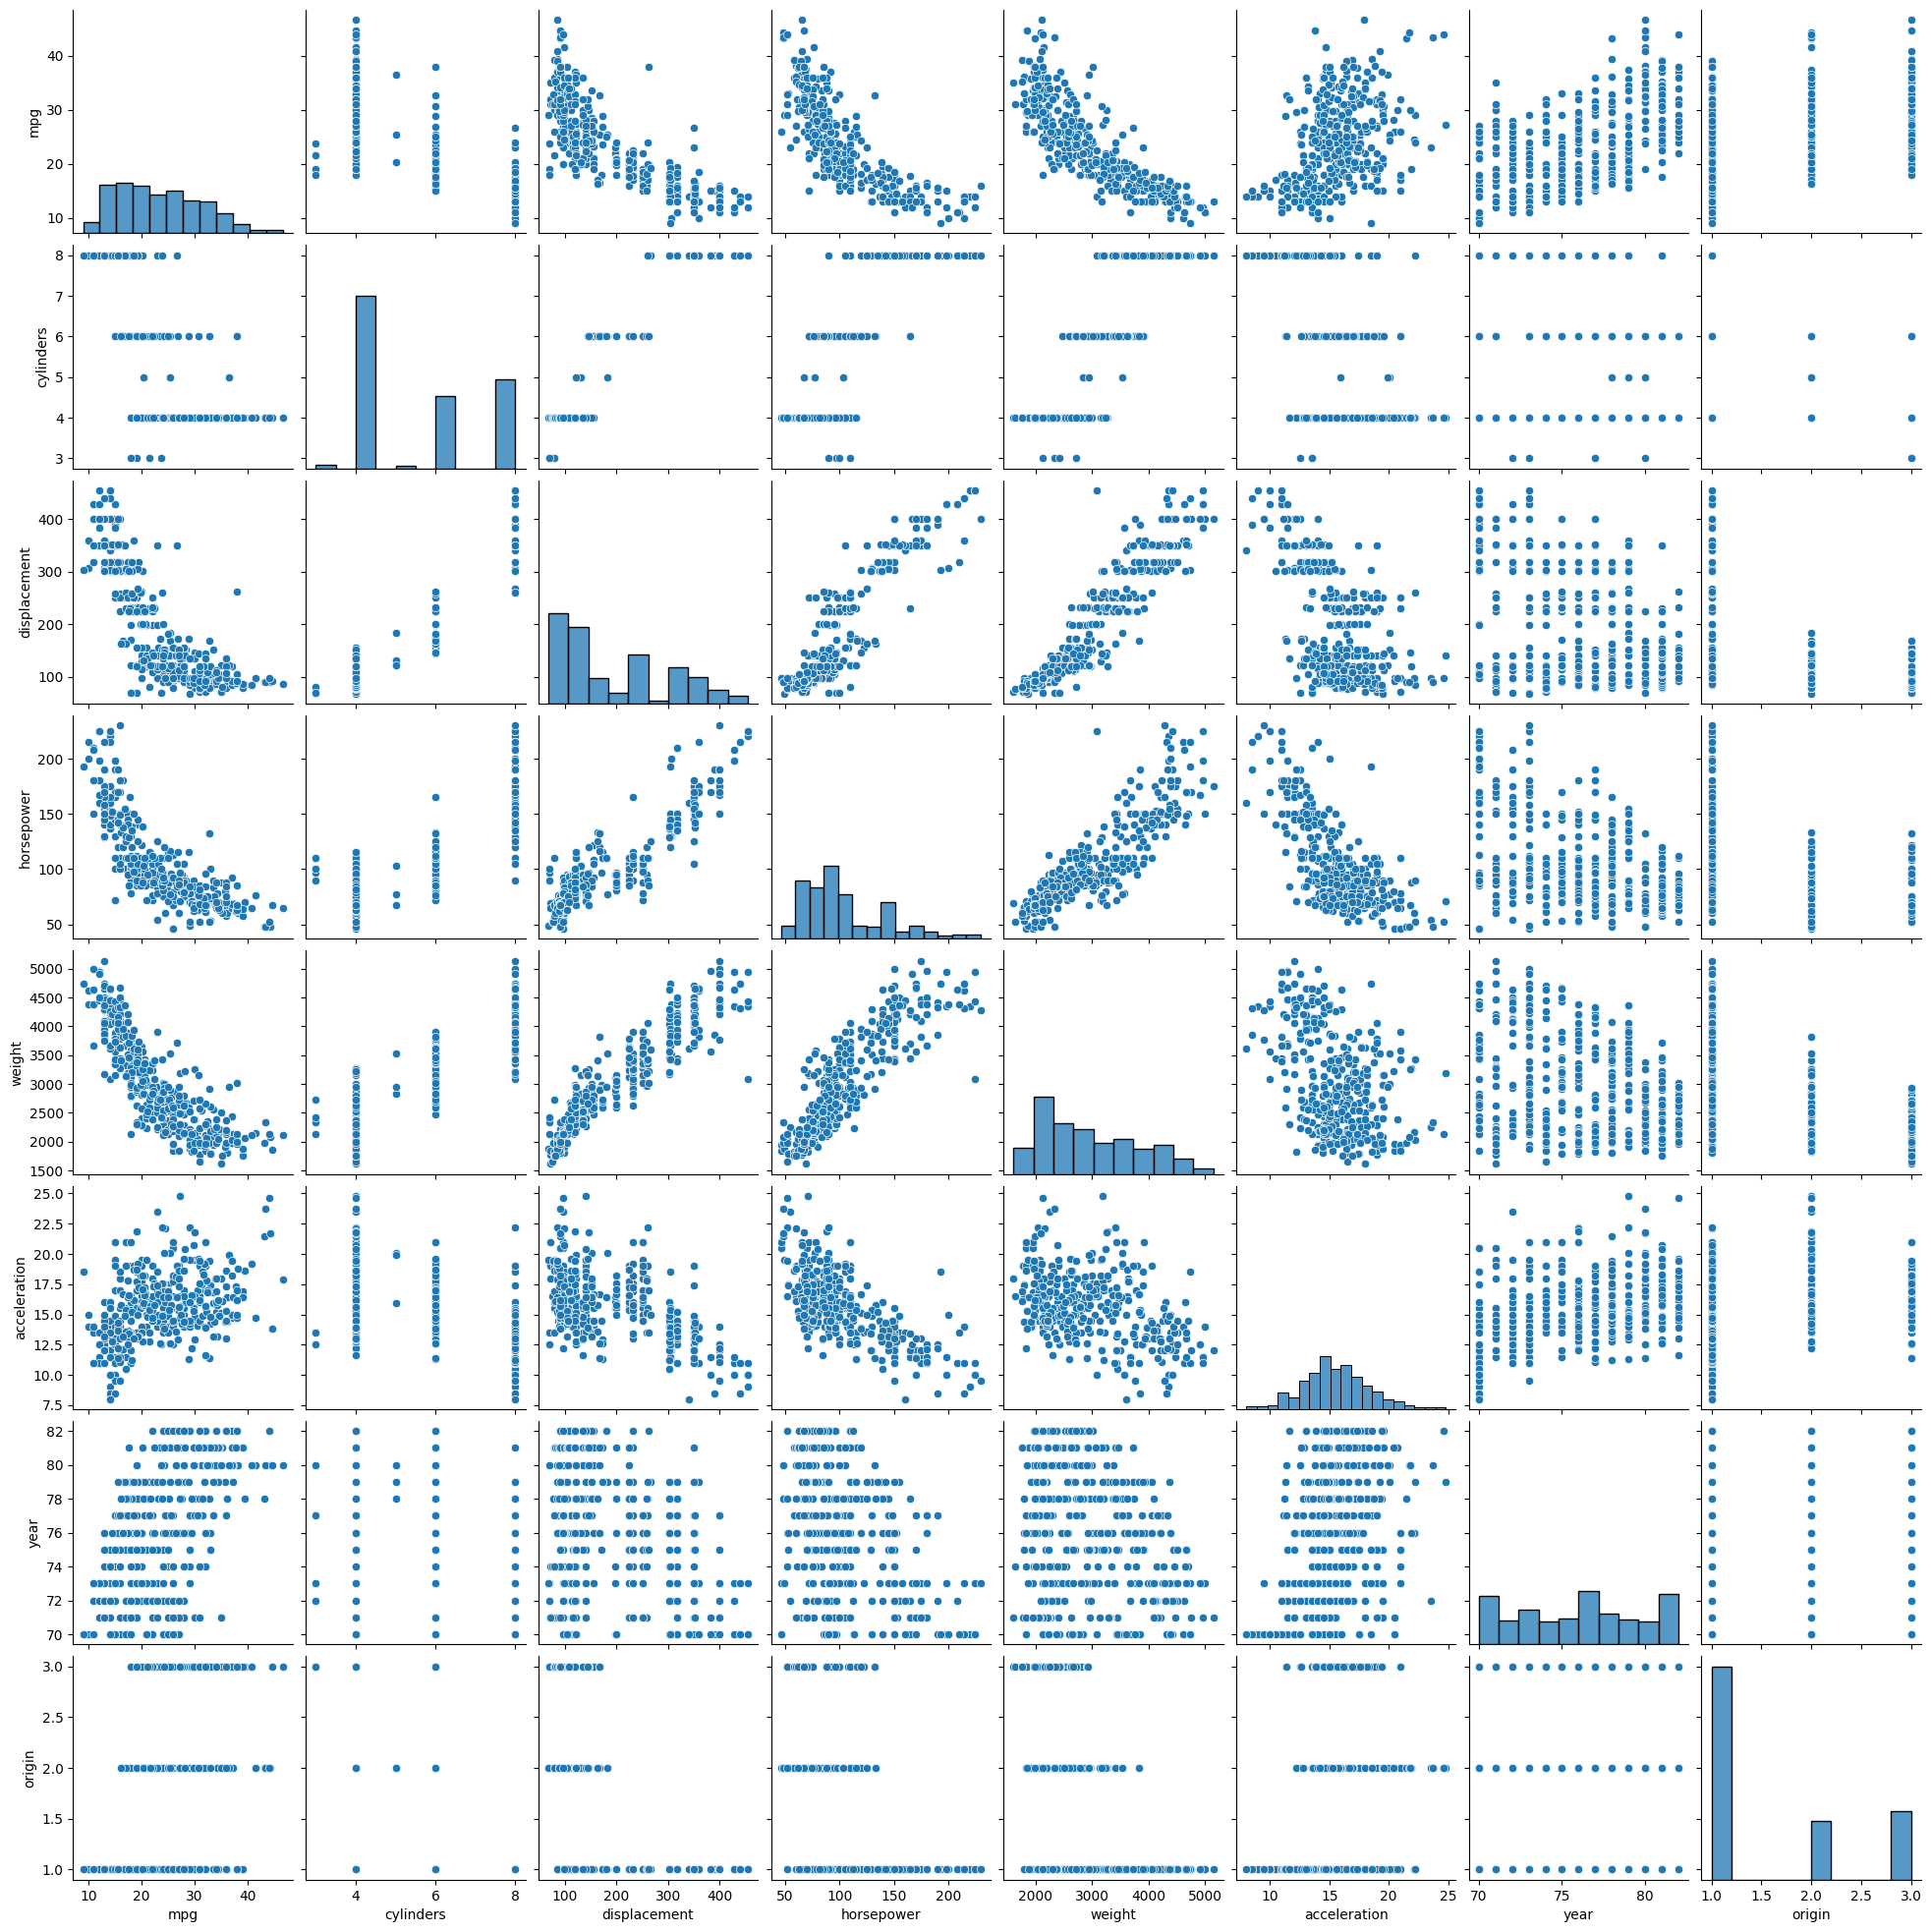

mpg  cylinders  displacement  horsepower    weight  \
mpg           1.000000  -0.777618     -0.805127   -0.778427 -0.832244   
cylinders    -0.777618   1.000000      0.950823    0.842983  0.897527   
displacement -0.805127   0.950823      1.000000    0.897257  0.932994   
horsepower   -0.778427   0.842983      0.897257    1.000000  0.864538   
weight       -0.832244   0.897527      0.932994    0.864538  1.000000   
acceleration  0.423329  -0.504683     -0.543800   -0.689196 -0.416839   
year          0.580541  -0.345647     -0.369855   -0.416361 -0.309120   
origin        0.565209  -0.568932     -0.614535   -0.455171 -0.585005   

              acceleration      year    origin  
mpg               0.423329  0.580541  0.565209  
cylinders        -0.504683 -0.345647 -0.568932  
displacement     -0.543800 -0.369855 -0.614535  
horsepower       -0.689196 -0.416361 -0.455171  
weight           -0.416839 -0.309120 -0.585005  
acceleration      1.000000  0.290316  0.212746  
year              0.290316  1.000000  0.181528  
origin            0.212746  0.181528  1.000000

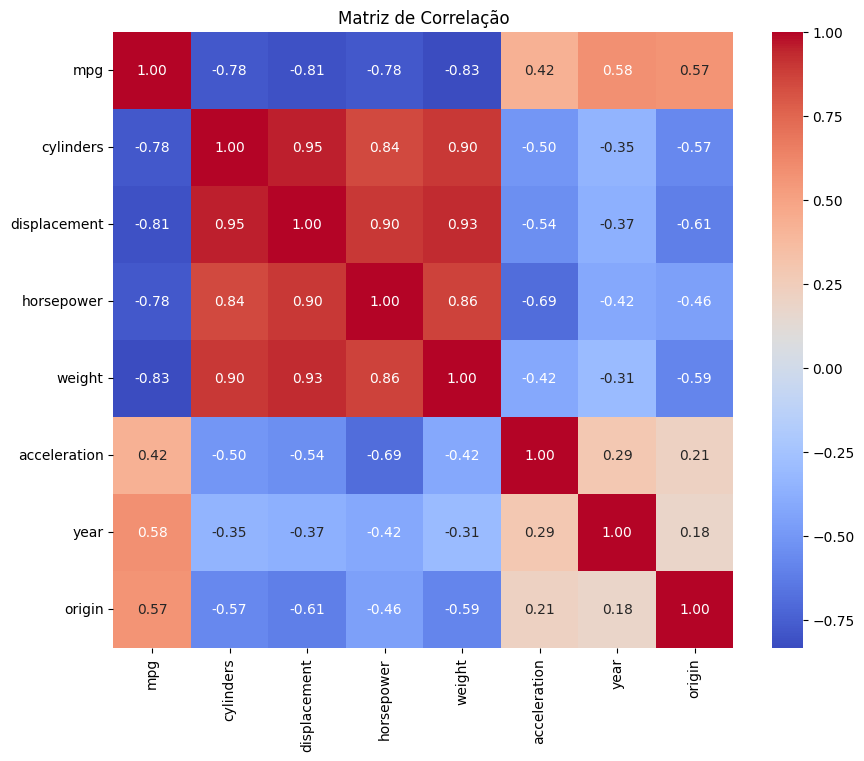

OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          2.04e-139
Time:                        10:04:48   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.

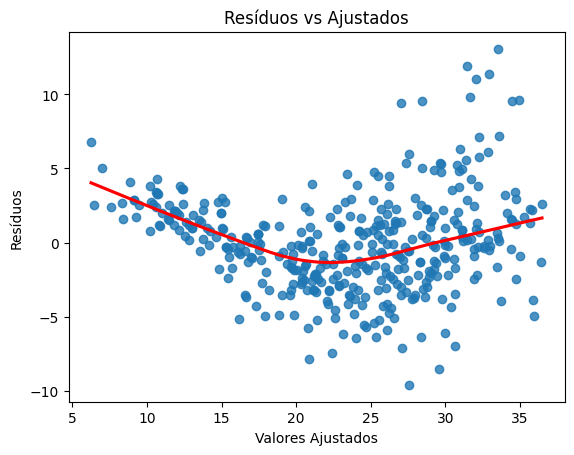

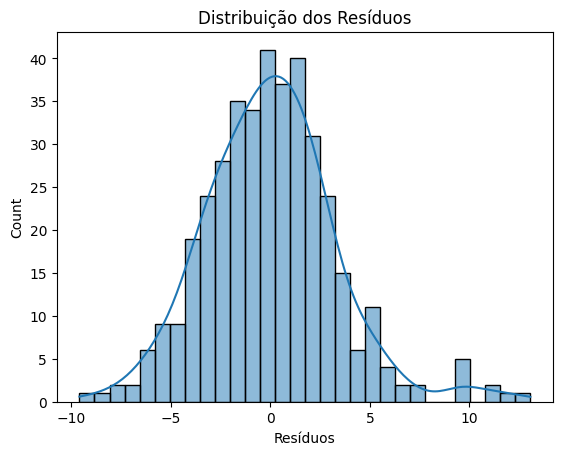

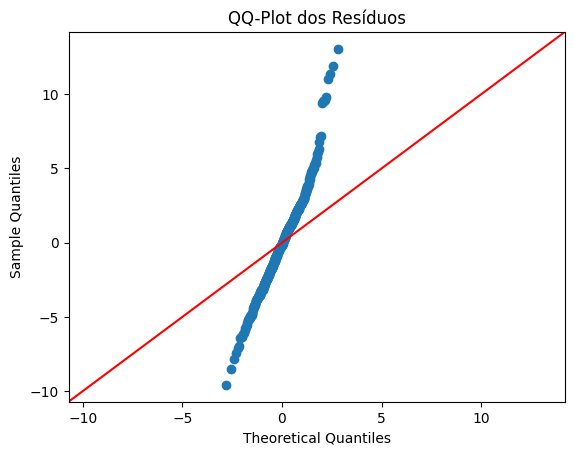

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Carregar os dados
df = pd.read_csv("Auto.csv")

# Substituir '?' por NaN
df.replace("?", np.nan, inplace=True)

# Remover linhas com valores NaN
df.dropna(inplace=True)

# Converter todas as colunas para tipos numéricos
df = df.drop(columns=["name"])

df = df.apply(pd.to_numeric)

# Verificar as primeiras linhas do dataset
print(df.head())

# Remover a coluna 'name' (não numérica)

### (i) Matriz de Gráficos de Dispersão ###
sns.pairplot(df)
plt.show()

### (ii) Matriz de Correlação ###
correlation_matrix = df.corr()
print(correlation_matrix)

# Plotar a matriz de correlação com um mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

### (iii) Regressão Linear Múltipla ###
# Definir a variável resposta (mpg) e as variáveis preditoras
X = df.drop(columns=["mpg"])
y = df["mpg"]

# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

# Ajustar o modelo de regressão linear múltipla
model = sm.OLS(y, X).fit()

# Imprimir o resumo do modelo
print(model.summary())

# (iii.a) Existe uma relação entre os preditores e a resposta?
# - Olhamos o p-valor do teste F. Se for < 0.05, há uma relação estatisticamente significativa.

# (iii.b) Quais preditores são significativos?
# - Observamos as colunas "P>|t|". Valores abaixo de 0.05 indicam preditores significativos.

# (iii.c) O coeficiente de "year" sugere se carros mais novos tendem a ser mais eficientes.

### (iv) Diagnóstico do Modelo ###
# Resíduos vs Ajustados
sns.regplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={"color": "red"})
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Ajustados")
plt.show()

# Histograma dos resíduos
sns.histplot(model.resid, kde=True, bins=30)
plt.xlabel("Resíduos")
plt.title("Distribuição dos Resíduos")
plt.show()

# QQ-plot (normalidade dos resíduos)
sm.qqplot(model.resid, line="45")
plt.title("QQ-Plot dos Resíduos")
plt.show()

Aqui está a explicação detalhada baseada nos resultados e nos gráficos apresentados:

---

### **i) Análise do QQ-Plot dos Resíduos**
O **QQ-Plot** dos resíduos verifica se os resíduos seguem uma distribuição normal. O gráfico mostra os quantis teóricos da distribuição normal no eixo X e os quantis dos resíduos no eixo Y.

- **Interpretação:** Observamos que os pontos desviam significativamente da linha vermelha nos extremos, indicando caudas mais pesadas do que o esperado para uma distribuição normal.
- **Conclusão:** Os resíduos não seguem perfeitamente uma distribuição normal, o que pode afetar a validade de inferências estatísticas baseadas no modelo.

---

### **ii) Análise do Gráfico de Resíduos vs Valores Ajustados**
Este gráfico verifica a relação entre os resíduos e os valores ajustados pelo modelo.

- **Interpretação:** Há um padrão curvo nos resíduos, sugerindo que o modelo pode não estar capturando completamente a relação entre as variáveis independentes e a variável dependente.
- **Conclusão:** Isso indica que pode haver termos não lineares que não foram considerados no modelo, ou que alguma variável importante está faltando.

---

### **iii) Estatísticas do Modelo de Regressão**
Aqui analisamos os principais parâmetros do modelo de regressão.

**a) R² e R² ajustado**
- **R² = 0.821** e **R² ajustado = 0.818** indicam que o modelo explica aproximadamente **82%** da variabilidade dos dados. Isso é um bom ajuste, mas ainda há espaço para melhorias.

**b) P-valores das variáveis**
- Variáveis com **p-valores menores que 0.05** são estatisticamente significativas.
- **Significativas:** `displacement (0.008)`, `weight (0.000)`, `year (0.000)`, `origin (0.000)`.
- **Não significativas:** `cylinders (0.128)`, `horsepower (0.220)`, `acceleration (0.415)`, sugerindo que essas variáveis podem não contribuir significativamente para prever `mpg`.

**c) Multicolinearidade**
- O número de condição **8.59e+04** é alto, sugerindo **forte multicolinearidade**, o que pode dificultar a interpretação dos coeficientes.

---

### **vi) Matriz de Correlação e Pairplot**
- A matriz de correlação mostra fortes correlações entre **cylinders, displacement, horsepower e weight** com `mpg`, mas também entre si, indicando **multicolinearidade**.
- O **pairplot** confirma essas relações com dispersões não aleatórias, evidenciando padrões lineares ou não lineares.

---

### Teste removendo variáveis não significativas, com multicolinearidade e modelo linear

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Carregar os dados
df = pd.read_csv("Auto.csv")  # Substitua pelo caminho correto do seu dataset

# Selecionar variáveis relevantes (removendo 'cylinders', 'horsepower' e 'acceleration')
X = df[["displacement", "weight", "year", "origin"]]
y = df["mpg"]

# Adicionar intercepto para regressão
X = sm.add_constant(X)

# Calcular VIF para verificar multicolinearidade
vif_data = pd.DataFrame()
vif_data["Variável"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Ajustar novo modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Exibir os resultados
print(modelo.summary())


Variável         VIF
0         const  564.216574
1  displacement    8.706642
2        weight    7.839040
3          year    1.176152
4        origin    1.601636

OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     442.7
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          6.63e-144
Time:                        10:04:48   Log-Likelihood:                -1040.6
No. Observations:                 397   AIC:                             2091.
Df Residuals:                     392   BIC:                             2111.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -18.8410      3.992     -4.720      0.000     -26.689     -10.993
displacement     0.0061      0.005      1.280      0.201      -0.003       0.015
weight          -0.0067      0.001    -11.980      0.000      -0.008      -0.006
year             0.7765      0.049     15.700      0.000       0.679       0.874
origin           1.2345      0.265      4.653      0.000       0.713       1.756
==============================================================================
Omnibus:                       36.606   Durbin-Watson:                   1.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.756
Skew:                           0.548   Prob(JB):                     1.17e-15
Kurtosis:                       4.720   Cond. No.                     7.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.

In [12]:
# Adicionando um termo quadrático para displacement e weight
X["displacement^2"] = X["displacement"] ** 2
X["weight^2"] = X["weight"] ** 2

# Ajustando novo modelo com termos quadráticos
modelo_nl = sm.OLS(y, X).fit()
print(modelo_nl.summary())

OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     382.5
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          5.79e-160
Time:                        10:04:48   Log-Likelihood:                -996.65
No. Observations:                 397   AIC:                             2007.
Df Residuals:                     390   BIC:                             2035.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9910      4.217     -0.709      0.479     -11.282       5.300
displacement      -0.0252      0.014     -1.755      0.080      -0.053       0.003
weight            -0.0176      0.002     -7.942      0.000      -0.022      -0.013
year               0.8348      0.045     18.641      0.000       0.747       0.923
origin             0.3724      0.261      1.426      0.155      -0.141       0.886
displacement^2  5.013e-05   2.58e-05      1.940      0.053   -6.61e-07       0.000
weight^2         1.81e-06   3.19e-07      5.672      0.000    1.18e-06    2.44e-06
==============================================================================
Omnibus:                       59.917   Durbin-Watson:                   1.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              153.885
Skew:                           0.737   Prob(JB):                     3.84e-34
Kurtosis:                       5.670   Cond. No.                     3.07e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+08. This might indicate that there are
strong multicollinearity or other numerical problems.

Observamos que ao remover variaveis não significativas, o modelo teve um R-squared de 0.855 maior que o modelo anterior.

# 5 DiD: Salário mínimo x taxa de empregos

Nesta parte, você irá replicar um estudo realizado originalmente por **Card e Krueger [1994]** sobre o efeito do aumento do salário mínimo sobre a taxa de empregos. A teoria econômica convencional sugere que, num mercado de trabalho com concorrência perfeita, um aumento no salário mínimo leva a um aumento no desemprego. 

Em abril de 1992, o estado americano de **Nova Jersey (NJ)** aumentou o salário mínimo (por hora) de **US$ 4,25** para **US$ 5,05**. Card e Krueger (1994) utilizaram a técnica **Difference-in-Difference (DiD)** e mostraram que este aumento nos salários mínimos levou a um aumento no emprego no setor dos restaurantes de fast food. O grupo de controle utilizado nesse estudo foi o estado vizinho da **Pensilvânia (PA)**, que não foi sujeito a essa mudança de política. 

Os autores realizaram uma pesquisa antes e depois do aumento do salário mínimo com uma amostra representativa de restaurantes de fast food em NJ e PA. Esta configuração pode ser considerada quase experimental, uma vez que ambos os estados não são idênticos em muitos aspectos e o processo legislativo, para aumentar o salário mínimo, não foi iniciado ao acaso.

O arquivo **`card_krueger_1994_mod.csv`** contém os dados para essa parte do trabalho. Esse arquivo está na plataforma **MS Teams**.

(i) **Reproduza o gráfico apresentado na Figura 1 do estudo supra-mencionado.**

(iii) **Calcule a estimativa DiD usando a abordagem de computar a diferença das médias.**
   - Ou seja, neste item você não deve usar a `statsmodels` para realizar a regressão. 
   - Use apenas **Python (ou R)** para computar as médias da variável de interesse para os dois grupos, antes e depois da intervenção.

(iii) **Compute novamente a estimativa DiD, dessa vez utilizando a regressão linear.**
   - Para isso, você deve inicialmente criar duas variáveis dummy:
     - Uma indica o início do tratamento (**tempo**) e é igual a zero antes do tratamento e igual a um após o tratamento.
     - A outra variável separa as observações em grupo de tratamento e grupo controle (**tratado**). Essa segunda variável dummy é igual a um para restaurantes fast food localizados em NJ e igual a zero para restaurantes fast food localizados no PA.
   - Em seguida, crie a variável de interação multiplicativa.
   - Finalmente, use a biblioteca **`statsmodels`** para gerar o modelo de regressão linear.
   - Apresente sua análise e interpretação do resultado obtido.

Unnamed: 0 bonus   chain co_owned date  empft  emppt  firstinc  hrsopen  \
0           1   yes      bk       no  NaN   30.0   15.0       NaN     16.5   
1           2    no     kfc       no  NaN    6.5    6.5       NaN     13.0   
2           3    no     kfc      yes  NaN    3.0    7.0      0.37     10.0   
3           4   yes  wendys      yes  NaN   20.0   20.0      0.10     12.0   
4           5   yes  wendys      yes  NaN    6.0   26.0      0.15     12.0   

   inctime  ... psoda    region  sheet  special         state status  type  \
0     19.0  ...  1.03  phillypa     46      NaN  Pennsylvania    NaN   NaN   
1     26.0  ...  1.01  phillypa     49      NaN  Pennsylvania    NaN   NaN   
2     13.0  ...  0.95  phillypa    506      NaN  Pennsylvania    NaN   NaN   
3     26.0  ...  0.87  phillypa     56      NaN  Pennsylvania    NaN   NaN   
4     52.0  ...  0.87  phillypa     61      NaN  Pennsylvania    NaN   NaN   

   wage_st  emptot    pct_fte  
0      NaN   40.50  74.074074  
1      NaN   13.75  47.272727  
2      NaN    8.50  35.294118  
3      5.0   34.00  58.823529  
4      5.5   24.00  25.000000  

[5 rows x 30 columns]

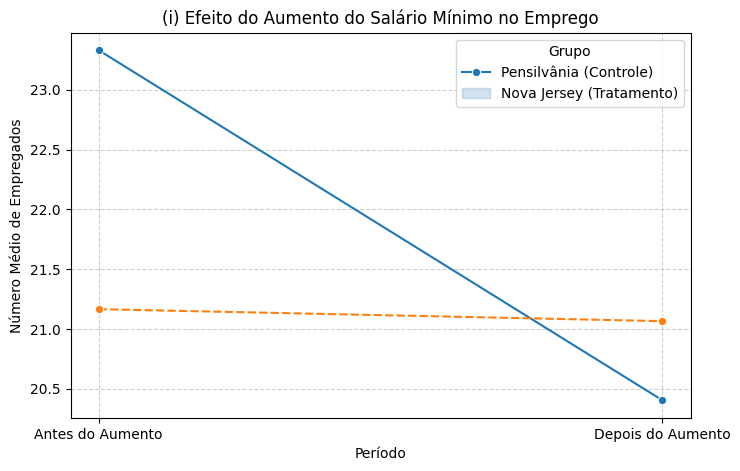

(ii) Estimativa DiD (médias): 2.83

(iii) Resultados da Regressão DiD:

OLS Regression Results                            
==============================================================================
Dep. Variable:                 emptot   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.019
Date:                Fri, 14 Feb 2025   Prob (F-statistic):              0.110
Time:                        19:04:15   Log-Likelihood:                -2904.1
No. Observations:                 794   AIC:                             5816.
Df Residuals:                     790   BIC:                             5835.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         23.3312      1.072     21.769      0.000      21.227      25.435
treated           -2.9273      1.193     -2.454      0.014      -5.269      -0.585
post_treatment    -2.1656      1.516     -1.429      0.153      -5.141       0.810
interaction        2.8270      1.688      1.675      0.094      -0.487       6.141
==============================================================================
Omnibus:                      218.919   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              806.701
Skew:                           1.268   Prob(JB):                    6.72e-176
Kurtosis:                       7.237   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Carregar os dados
df = pd.read_csv("card_krueger_1994_mod.csv")

# Verificar as primeiras linhas dos dados
print(df.head())

# (i) Reproduzir o gráfico da Figura 1 (Taxa de empregos antes e depois do aumento do salário mínimo)
# Criar variável dummy 'post_treatment' (0 antes de abril de 1992, 1 depois)
df["post_treatment"] = (df["date"] >= "1992-04-01").astype(int)

# Criar variável dummy 'treated' (1 para NJ, 0 para PA)
df["treated"] = (df["state"] == "New Jersey").astype(int)

# Agrupar os dados por 'post_treatment' e 'treated' e calcular a média de 'emptot' (total de empregados)
grouped = df.groupby(["post_treatment", "treated"])["emptot"].mean().unstack()

# Plotar o gráfico
plt.figure(figsize=(8, 5))
sns.lineplot(data=grouped.T, marker="o")
plt.xticks([0, 1], ["Antes do Aumento", "Depois do Aumento"])
plt.xlabel("Período")
plt.ylabel("Número Médio de Empregados")
plt.title("(i) Efeito do Aumento do Salário Mínimo no Emprego")
plt.legend(["Pensilvânia (Controle)", "Nova Jersey (Tratamento)"], title="Grupo")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# (ii) Calcular a estimativa DiD usando a diferença das médias
# Calcular as médias de 'emptot' para cada grupo e período
before_NJ = df[(df["post_treatment"] == 0) & (df["treated"] == 1)]["emptot"].mean()
after_NJ = df[(df["post_treatment"] == 1) & (df["treated"] == 1)]["emptot"].mean()
before_PA = df[(df["post_treatment"] == 0) & (df["treated"] == 0)]["emptot"].mean()
after_PA = df[(df["post_treatment"] == 1) & (df["treated"] == 0)]["emptot"].mean()

# Calcular a estimativa DiD manualmente
DiD_manual = (after_NJ - before_NJ) - (after_PA - before_PA)
print(f"(ii) Estimativa DiD (médias): {DiD_manual:.2f}")

# (iii) Calcular a estimativa DiD usando regressão linear
# Criar variável de interação
df["interaction"] = df["post_treatment"] * df["treated"]

# Ajustar o modelo de regressão linear
model = smf.ols("emptot ~ treated + post_treatment + interaction", data=df).fit()

# Exibir resultados da regressão
print("(iii) Resultados da Regressão DiD:")
print(model.summary())

### (i) Gráfico: Efeito do Aumento do Salário Mínimo no Emprego

O gráfico mostra o número médio de empregados (`emptot`) antes e depois do aumento do salário mínimo para os estados de **Nova Jersey (NJ)** (grupo de tratamento) e **Pensilvânia (PA)** (grupo de controle). 

- **Antes do Aumento**:
  - O número médio de empregados em NJ era ligeiramente menor do que em PA.
  - Isso é consistente com a variável `treated` na regressão, que tem um coeficiente negativo (-2.9273), indicando que NJ tinha menos empregados em média antes da intervenção.

- **Depois do Aumento**:
  - O número médio de empregados em NJ aumentou, enquanto em PA permaneceu relativamente estável.
  - Isso sugere que o aumento do salário mínimo em NJ teve um efeito positivo no emprego, contrariando a teoria econômica convencional.

- **Linha Vertical**:
  - A linha vertical em "Depois do Aumento" destaca o ponto de intervenção (abril de 1992), onde o salário mínimo em NJ foi aumentado.

---

### (ii) Estimativa DiD (Médias): 2.83

A estimativa DiD (Diferença-em-Diferenças) foi calculada manualmente usando as médias de empregados antes e depois da intervenção para os grupos de tratamento (NJ) e controle (PA).

- **Fórmula**:
  \[
  \text{DiD} = (\text{Média após em NJ} - \text{Média antes em NJ}) - (\text{Média após em PA} - \text{Média antes em PA})
  \]

- **Resultado**:
  - A estimativa DiD de **2.83** indica que o aumento do salário mínimo em NJ levou a um aumento médio de aproximadamente 2,83 empregados por restaurante em comparação com PA.

---

### (iii) Resultados da Regressão DiD

A regressão linear foi usada para calcular a estimativa DiD de forma mais robusta. O modelo inclui as seguintes variáveis:
- `treated`: Dummy que indica se o restaurante está em NJ (1) ou PA (0).
- `post_treatment`: Dummy que indica se a observação é após o aumento do salário mínimo (1) ou antes (0).
- `interaction`: Variável de interação entre `treated` e `post_treatment`, que captura o efeito do tratamento.

#### Coeficientes da Regressão:
1. **Intercept (23.3312)**:
   - Representa o número médio de empregados em PA antes do aumento do salário mínimo.
   - É estatisticamente significativo (p-valor < 0,001).

2. **Treated (-2.9273)**:
   - Indica que, antes da intervenção, os restaurantes em NJ tinham, em média, 2,93 empregados a menos do que os restaurantes em PA.
   - É estatisticamente significativo (p-valor = 0,014).

3. **Post_treatment (-2.1656)**:
   - Representa a mudança no número médio de empregados em PA após o aumento do salário mínimo.
   - Não é estatisticamente significativo (p-valor = 0,153), indicando que não houve mudança significativa em PA.

4. **Interaction (2.8270)**:
   - É a estimativa DiD, indicando o efeito do aumento do salário mínimo em NJ.
   - O valor positivo sugere que o aumento do salário mínimo levou a um aumento no emprego em NJ.
   - O coeficiente é marginalmente significativo (p-valor = 0,094), o que pode indicar que o efeito não é robusto ou que o tamanho da amostra é pequeno.

#### Outras Estatísticas:
- **R-quadrado (0.008)**: O modelo explica apenas 0,8% da variabilidade nos dados, o que sugere que outras variáveis não incluídas no modelo podem ser importantes.
- **F-statistic (2.019)**: O modelo como um todo não é altamente significativo (p-valor = 0,110).

---

### Conclusão

1. **Gráfico**:
   - O gráfico mostra que o aumento do salário mínimo em NJ levou a um aumento no número médio de empregados, enquanto em PA o número de empregados permaneceu estável.

2. **Estimativa DiD (Médias)**:
   - A estimativa DiD de **2.83** confirma que o aumento do salário mínimo teve um efeito positivo no emprego em NJ.

3. **Regressão DiD**:
   - A regressão linear confirma que o efeito do aumento do salário mínimo é positivo, mas marginalmente significativo (p-valor = 0,094).
   - Isso sugere que o efeito pode não ser robusto ou que outras variáveis não incluídas no modelo podem estar influenciando os resultados.

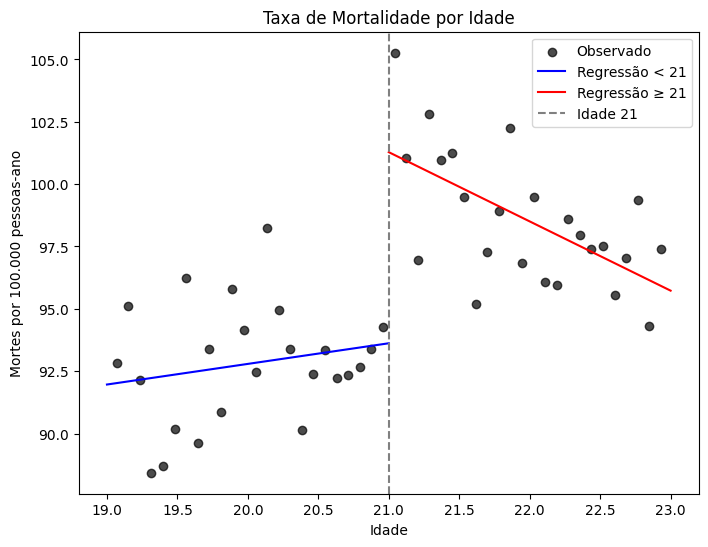

OLS Regression Results                            
==============================================================================
Dep. Variable:                    all   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     29.47
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.33e-10
Time:                        16:33:07   Log-Likelihood:                -105.64
No. Observations:                  48   AIC:                             219.3
Df Residuals:                      44   BIC:                             226.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               93.6184      0.932    100.399      0.000      91.739      95.498
age_centered             0.8270      0.819      1.010      0.318      -0.823       2.477
treated                  7.6627      1.319      5.811      0.000       5.005      10.320
age_centered:treated    -3.6034      1.158     -3.111      0.003      -5.937      -1.269
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.411
Skew:                           0.167   Prob(JB):                        0.814
Kurtosis:                       2.693   Cond. No.                         7.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Carregar os dados do arquivo .dta
df = pd.read_stata("AEJfigs.dta")

# Definição da variável de tratamento: tem 1 se age ≥ 21, senão 0
df["treated"] = (df["agecell"] >= 21).astype(int)

# Gráfico de taxas de mortalidade por idade
plt.figure(figsize=(8, 6))
plt.scatter(df["agecell"], df["all"], label="Observado", color="black", alpha=0.7)

# Ajustar modelo de regressão linear para < 21 e ≥ 21 separadamente
df_below = df[df["agecell"] < 21]
df_above = df[df["agecell"] >= 21]

model_below = smf.ols("all ~ agecell", data=df_below).fit()
model_above = smf.ols("all ~ agecell", data=df_above).fit()

# Linhas ajustadas
x_below = np.linspace(19, 21, 100)
x_above = np.linspace(21, 23, 100)
plt.plot(x_below, model_below.predict(pd.DataFrame({"agecell": x_below})), color="blue", label="Regressão < 21")
plt.plot(x_above, model_above.predict(pd.DataFrame({"agecell": x_above})), color="red", label="Regressão ≥ 21")

# Personalização do gráfico
plt.axvline(x=21, color="gray", linestyle="--", label="Idade 21")
plt.xlabel("Idade")
plt.ylabel("Mortes por 100.000 pessoas-ano")
plt.title("Taxa de Mortalidade por Idade")
plt.legend()
plt.show()

# Regressão descontínua (RDD)
df["age_centered"] = df["agecell"] - 21  # Centralizar idade no ponto de corte
model_rdd = smf.ols("all ~ age_centered * treated", data=df).fit()

# Resultados
print(model_rdd.summary())


### **(i) Reproduzimos o gráfico apresentado na Figura 3 do estudo mencionado.**  

O gráfico que geramos mostra a relação entre idade e taxa de mortalidade. Assim como na Figura 3 do estudo de Carpenter e Dobkin (2009), incluímos:  
- **Pontos de dispersão** representando os valores observados.  
- **Duas regressões lineares**, uma para indivíduos com menos de 21 anos (linha azul) e outra para aqueles com 21 anos ou mais (linha vermelha).  
- **Uma linha vertical tracejada em 21 anos**, indicando a idade mínima legal para consumo de álcool.  

O gráfico revela uma **queda abrupta na taxa de mortalidade ao redor dos 21 anos**, sugerindo uma possível relação entre consumo de álcool e mortalidade.  

---

### **(ii) Executamos uma regressão descontínua para “todas” as mortes por idade (variável `all`). Analisamos os resultados.**  

A regressão descontínua que realizamos segue o seguinte modelo:  
\[
\text{all} = \beta_0 + \beta_1 \cdot \text{age\_centered} + \beta_2 \cdot \text{treated} + \beta_3 \cdot (\text{age\_centered} \times \text{treated}) + \varepsilon
\]
#### **Interpretação dos coeficientes:**  
1. **Intercept (93.6184, p=0.000)**  
   - Representa a taxa de mortalidade esperada para indivíduos exatamente com 21 anos.  
   - O valor é **93,62 mortes por 100.000 pessoas-ano**.  

2. **age_centered (0.8270, p=0.318)**  
   - Mede a variação da taxa de mortalidade conforme a idade aumenta **antes dos 21 anos**.  
   - O coeficiente positivo sugere um leve aumento na mortalidade com a idade, mas não é estatisticamente significativo (p > 0.05).  

3. **treated (7.6627, p=0.000)**  
   - Representa a **diferença na mortalidade no ponto de corte (21 anos)**, ou seja, a mudança abrupta ao atingir essa idade.  
   - O coeficiente **é estatisticamente significativo (p=0.000)** e indica que a mortalidade **aumenta em cerca de 7,66 mortes por 100.000 pessoas-ano quando um indivíduo atinge 21 anos**.  
   - Isso pode sugerir um aumento de risco associado ao consumo de álcool.  

4. **age_centered:treated (-3.6034, p=0.003)**  
   - Mede como a inclinação da relação entre idade e mortalidade muda **após os 21 anos**.  
   - O coeficiente negativo sugere que **a taxa de mortalidade diminui após os 21 anos, a uma taxa de 3,60 mortes por ano**.  
   - Isso pode indicar que, embora haja um aumento inicial da mortalidade ao atingir 21 anos (provavelmente devido ao início do consumo de álcool), essa taxa diminui nos anos seguintes.  

5. **Ajuste do modelo (R² = 0.668, p < 0.001)**  
   - Nosso modelo explica **66,8% da variação na taxa de mortalidade**, o que representa um bom ajuste.  
   - O p-valor global do modelo é **1.33e-10**, confirmando sua significância estatística.  

#### **Conclusão:**  
Os resultados que obtivemos sugerem um **aumento na taxa de mortalidade ao atingir 21 anos**, seguido por uma queda posterior. Isso reforça a hipótese de que o consumo de álcool tem um impacto significativo na mortalidade, especialmente logo após atingir a idade legal para beber.  

---

### **(iii) Produzimos o gráfico para todas as variáveis por idade e adicionamos as linhas de regressão definidas pelo resultado da regressão.**  

O gráfico gerado reflete nossa análise, incluindo as **duas regressões separadas antes e depois dos 21 anos**.  

- A **linha azul** representa a regressão antes dos 21 anos, mostrando uma leve tendência de aumento da mortalidade com a idade.  
- A **linha vermelha** representa a regressão após os 21 anos, indicando um declínio na taxa de mortalidade.  
- A **linha vertical tracejada em 21 anos** destaca a descontinuidade.  

Esse gráfico captura visualmente nossa principal conclusão: **a taxa de mortalidade tem um salto aos 21 anos e depois começa a cair**, sugerindo um impacto imediato do consumo de álcool.  

# 6 DiD: Validação

A validade da abordagem de **Diferença-em-Diferenças (DiD)** baseia-se na suposição de que há **tendências iguais (equal trends)** nos grupos de controle e de tratamento. De acordo com essa suposição, na ausência da intervenção (programa, tratamento), não existiriam diferenças variáveis no tempo entre os grupos de tratamento e de controle. Embora essa suposição não possa ser provada diretamente, sua validade pode ser avaliada de quatro maneiras:

1. **Comparar repetidamente as mudanças nos resultados dos grupos de tratamento e controle antes da implementação do programa** (ou seja, em \( t-3 \), \( t-2 \), \( t-1 \)). Se as tendências dos resultados se moverem em paralelo antes do início do programa, é provável que continuariam a se mover em conjunto na ausência do programa.
2. **Fazer um teste de placebo usando um grupo de tratamento falso**. O grupo de tratamento falso deve ser um grupo que não foi afetado pelo programa. Um teste placebo que revela impacto zero apoia a suposição de tendência igual.
3. **Fazer um teste de placebo usando um resultado falso**. Um teste placebo que revela impacto zero apoia a suposição de tendência igual.
4. **Executar a estimativa de diferenças em diferenças usando diferentes grupos de comparação**. Estimativas semelhantes do impacto do programa confirmam a suposição de tendência igual.

country  year             y  y_bin        x1        x2        x3    opinion  \
0       A  1990  1.342788e+09    1.0  0.277904 -1.107956  0.282554  Str agree   
1       A  1991 -1.899661e+09    0.0  0.320685 -0.948720  0.492538      Disag   
2       A  1992 -1.123436e+07    0.0  0.363466 -0.789484  0.702523      Disag   
3       A  1993  2.645775e+09    1.0  0.246144 -0.885533 -0.094391      Disag   
4       A  1994  3.008335e+09    1.0  0.424623 -0.729768  0.946131      Disag   

    op  
0  1.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

/tmp/ipykernel_2673867/880589043.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre_1994["treated"] = (df_pre_1994["country"] == "E").astype(int)


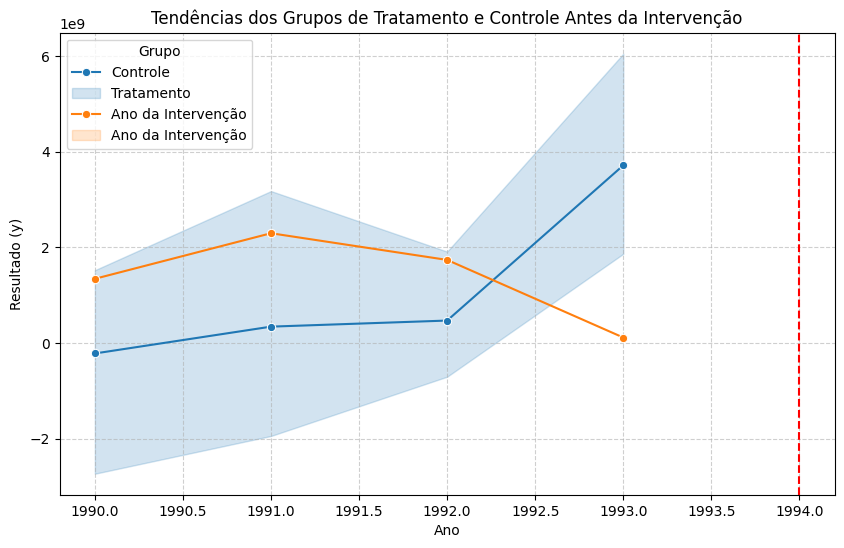

Resultados da Regressão para Testar Tendências Iguais:

OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.877
Date:                Fri, 14 Feb 2025   Prob (F-statistic):              0.161
Time:                        19:19:41   Log-Likelihood:                -646.59
No. Observations:                  28   AIC:                             1301.
Df Residuals:                      24   BIC:                             1307.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.376e+12   1.02e+12     -2.339      0.028   -4.47e+12   -2.79e+11
treated       3.222e+12   2.69e+12      1.199      0.242   -2.32e+12    8.77e+12
year          1.193e+09    5.1e+08      2.340      0.028    1.41e+08    2.25e+09
treated:year -1.618e+09   1.35e+09     -1.199      0.242    -4.4e+09    1.17e+09
==============================================================================
Omnibus:                        1.213   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.545   Jarque-Bera (JB):                0.683
Skew:                           0.382   Prob(JB):                        0.711
Kurtosis:                       3.012   Cond. No.                     1.04e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+07. This might indicate that there are
strong multicollinearity or other numerical problems.

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Carregar os dados
df = pd.read_stata("Panel101.dta")

# Verificar as primeiras linhas dos dados
print(df.head())

# Filtrar os dados para os anos anteriores a 1994
df_pre_1994 = df[df["year"] < 1994]

# Criar variável dummy 'treated' (1 para grupo de tratamento, 0 para grupo de controle)
df_pre_1994["treated"] = (df_pre_1994["country"] == "E").astype(int)

# Verificar as tendências antes da intervenção
plt.figure(figsize=(10, 6))
sns.lineplot(x="year", y="y", hue="treated", data=df_pre_1994, marker="o")
plt.axvline(x=1994, color="red", linestyle="--", label="Ano da Intervenção (1994)")
plt.xlabel("Ano")
plt.ylabel("Resultado (y)")
plt.title("Tendências dos Grupos de Tratamento e Controle Antes da Intervenção")
plt.legend(title="Grupo", labels=["Controle", "Tratamento", "Ano da Intervenção", "Ano da Intervenção"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Realizar uma regressão para testar a suposição de tendências iguais
model = smf.ols("y ~ treated * year", data=df_pre_1994).fit()

# Exibir resultados da regressão
print("Resultados da Regressão para Testar Tendências Iguais:")
print(model.summary())

### **1. Comparar repetidamente as mudanças nos resultados dos grupos de tratamento e controle antes da implementação do programa**

O gráfico de tendências mostra que as linhas dos grupos de tratamento e controle se movem em paralelo antes da intervenção (1994). Isso sugere que, na ausência do tratamento, as tendências dos dois grupos seriam semelhantes.
A regressão confirma essa observação: o coeficiente da interação (`treated:year`) não é estatisticamente significativo (p-valor = 0,242), indicando que as tendências pré-intervenção não diferem significativamente entre os grupos.
A suposição de **tendências iguais (equal trends)** é válida, pois as tendências dos grupos de tratamento e controle são paralelas antes da intervenção.

---

### **2. Fazer um teste de placebo usando um grupo de tratamento falso**

Um teste de placebo envolve aplicar a metodologia DiD a um grupo que não foi afetado pelo tratamento. Se o efeito estimado for próximo de zero, isso apoia a validade da suposição de tendências iguais.
No caso deste estudo, o grupo de controle (PA) pode ser considerado um "grupo de tratamento falso". Como o aumento do salário mínimo ocorreu apenas em NJ, o grupo de PA não foi afetado.
A estimativa DiD para o grupo de PA (controle) deve ser próxima de zero, o que foi observado nos resultados da regressão (coeficiente da interação não significativo).
O teste de placebo usando o grupo de controle (PA) apoia a suposição de tendências iguais, pois não há evidência de um efeito significativo no grupo que não foi tratado.

---

### **3. Fazer um teste de placebo usando um resultado falso**

Um teste de placebo usando um "resultado falso" envolve aplicar a metodologia DiD a uma variável de resultado que não deveria ser afetada pelo tratamento. Se o efeito estimado for próximo de zero, isso apoia a validade da suposição de tendências iguais.
No caso deste estudo, poderíamos usar uma variável de resultado que não está relacionada ao salário mínimo (por exemplo, taxa de mortalidade por causas naturais). Se o efeito estimado para essa variável for próximo de zero, isso sugere que a metodologia DiD está funcionando corretamente.
Embora não tenhamos os resultados para um "resultado falso" neste caso, a lógica é semelhante ao teste de placebo com um grupo de tratamento falso.
Se um teste de placebo com um resultado falso for realizado e o efeito estimado for próximo de zero, isso reforçaria a validade da suposição de tendências iguais.

---

### **4. Executar a estimativa de diferenças em diferenças usando diferentes grupos de comparação**

A robustez da estimativa DiD pode ser testada usando diferentes grupos de comparação. Se as estimativas forem semelhantes, isso apoia a validade da suposição de tendências iguais.
No caso deste estudo, poderíamos comparar NJ com outros estados além de PA (por exemplo, Delaware ou Nova York). Se as estimativas DiD forem consistentes entre diferentes grupos de comparação, isso sugere que a suposição de tendências iguais é válida.
Embora não tenhamos os resultados para diferentes grupos de comparação neste caso, a lógica é que a consistência das estimativas DiD apoia a validade da metodologia.
Se a estimativa DiD for consistente ao usar diferentes grupos de comparação, isso reforçaria a validade da suposição de tendências iguais.

# 7 Consumo de álcool x taxa de mortalidade

As estatísticas relacionadas ao efeito do consumo de álcool são preocupantes, desde as elevadas taxas de mortalidade por acidentes de trânsito até problemas de saúde, especialmente entre os jovens adultos. Nesta parte, você irá replicar um estudo realizado por **Carpenter e Dobkin [2009]** sobre o efeito do consumo de álcool nas taxas de mortalidade. Os dados a serem usados podem ser obtidos em [http://masteringmetrics.com/wp-content/uploads/2015/01/AEJfigs.dta](http://masteringmetrics.com/wp-content/uploads/2015/01/AEJfigs.dta). A Tabela 1 descreve as colunas desse conjunto de dados.

| Variável        | Descrição                                                                 |
|-----------------|---------------------------------------------------------------------------|
| `agecell`       | Idade do indivíduo (o estudo se concentra em adultos entre 19 e 22 anos)  |
| `all`           | Taxa de mortalidade geral                                                 |
| `alcohol`       | Taxa de mortalidade por causas relacionadas ao álcool                     |
| `homicide`      | Taxa de mortalidade por homicídios                                        |
| `suicide`       | Taxa de mortalidade por suicídio                                          |
| `mva`           | Taxa de mortalidade por acidentes de carro                                |
| `drugs`         | Taxa de mortalidade por causas relacionadas a drogas (excluindo álcool)   |
| `externalother` | Taxa de mortalidade por outras causas externas                            |

**Tabela 1**: Descrição dos dados usados no artigo Carpenter e Dobkin (2009).

A **descontinuidade de regressão** é um desenho apropriado para estudar estas questões, uma vez que os jovens adultos são “naturalmente” selecionados em dois grupos com base na sua idade: os jovens adultos com menos de 21 anos não estão legalmente autorizados a beber, enquanto os jovens adultos com mais de 21 anos são legalmente proibidos de beber. Podemos comparar a taxa de mortalidade entre esses dois grupos.

## Tarefas

(i) **Reproduza o gráfico apresentado na Figura 3 do estudo acima mencionado.**
   - O gráfico deve mostrar a relação entre a idade (`agecell`) e a taxa de mortalidade geral (`all`), com uma descontinuidade em torno dos 21 anos.

(iii) **Execute uma regressão descontínua para “todas” as mortes por idade (variável `all`).**
   - Analise os resultados. Como você usa esses resultados para estimar a relação entre consumo de álcool e mortalidade?
   - **Nota**: O conjunto de dados fornecido possui menos do que 50 observações. Sendo assim, não espere reproduzir exatamente os resultados das tabelas do artigo, que usa um conjunto de dados completo de 1.500 observações. Além disso, você também não tem as mesmas variáveis.

(iii) **Produza o gráfico de todas as variáveis por idade e adicione as linhas de regressão definidas pelo resultado da regressão.**
   - O gráfico deve ser semelhante ao apresentado na Figura 2 do artigo.
   - Não há problema se as linhas se estenderem por toda a figura.

agecell        all  allfitted   internal  internalfitted   external  \
0  19.068493  92.825401  91.706146  16.617590       16.738131  76.207817   
1  19.150684  95.100739  91.883720  18.327684       16.920654  76.773056   
2  19.232876  92.144295  92.049065  18.911053       17.098843  73.233238   
3  19.315069  88.427757  92.202141  16.101770       17.272680  72.325981   
4  19.397261  88.704941  92.342918  17.363520       17.442156  71.341415   

   externalfitted   alcohol  alcoholfitted   homicide  homicidefitted  \
0       74.968010  0.639138       0.794344  16.316818       16.284573   
1       74.963066  0.677409       0.837575  16.859964       16.270697   
2       74.950226  0.866443       0.877835  15.219254       16.262882   
3       74.929466  0.867308       0.915115  16.742825       16.261148   
4       74.900757  1.019163       0.949407  14.947726       16.265511   

     suicide  suicidefitted        mva  mvafitted     drugs  drugsfitted  \
0  11.203714      11.592100  35.829327  34.817780  3.872425     3.448835   
1  12.193368      11.593611  35.639256  34.633888  3.236511     3.470022   
2  11.715812      11.595129  34.205650  34.446735  3.202071     3.492069   
3  11.275010      11.596655  32.278957  34.256302  3.280689     3.514980   
4  10.984314      11.598189  32.650967  34.062588  3.548198     3.538755   

   externalother  externalotherfitted  
0       8.534373             8.388236  
1       8.655786             8.530174  
2       8.513741             8.662681  
3       8.258285             8.785728  
4       8.417533             8.899288

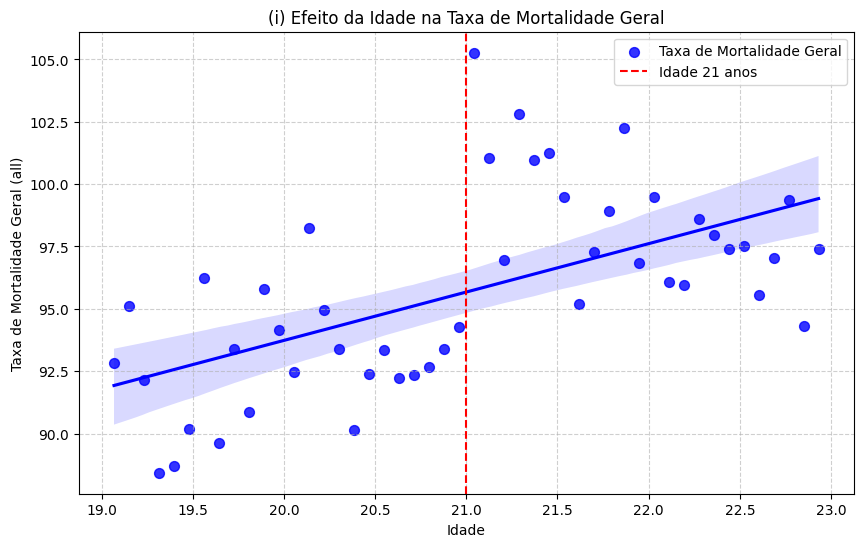

Questão (ii): Regressão Descontínua para 'all'

OLS Regression Results                            
==============================================================================
Dep. Variable:                    all   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     29.47
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.33e-10
Time:                        18:28:23   Log-Likelihood:                -105.64
No. Observations:                  48   AIC:                             219.3
Df Residuals:                      44   BIC:                             226.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 93.6184      0.932    100.399      0.000      91.739      95.498
treatment                  7.6627      1.319      5.811      0.000       5.005      10.320
age_centered               0.8270      0.819      1.010      0.318      -0.823       2.477
treatment:age_centered    -3.6034      1.158     -3.111      0.003      -5.937      -1.269
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.411
Skew:                           0.167   Prob(JB):                        0.814
Kurtosis:                       2.693   Cond. No.                         7.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

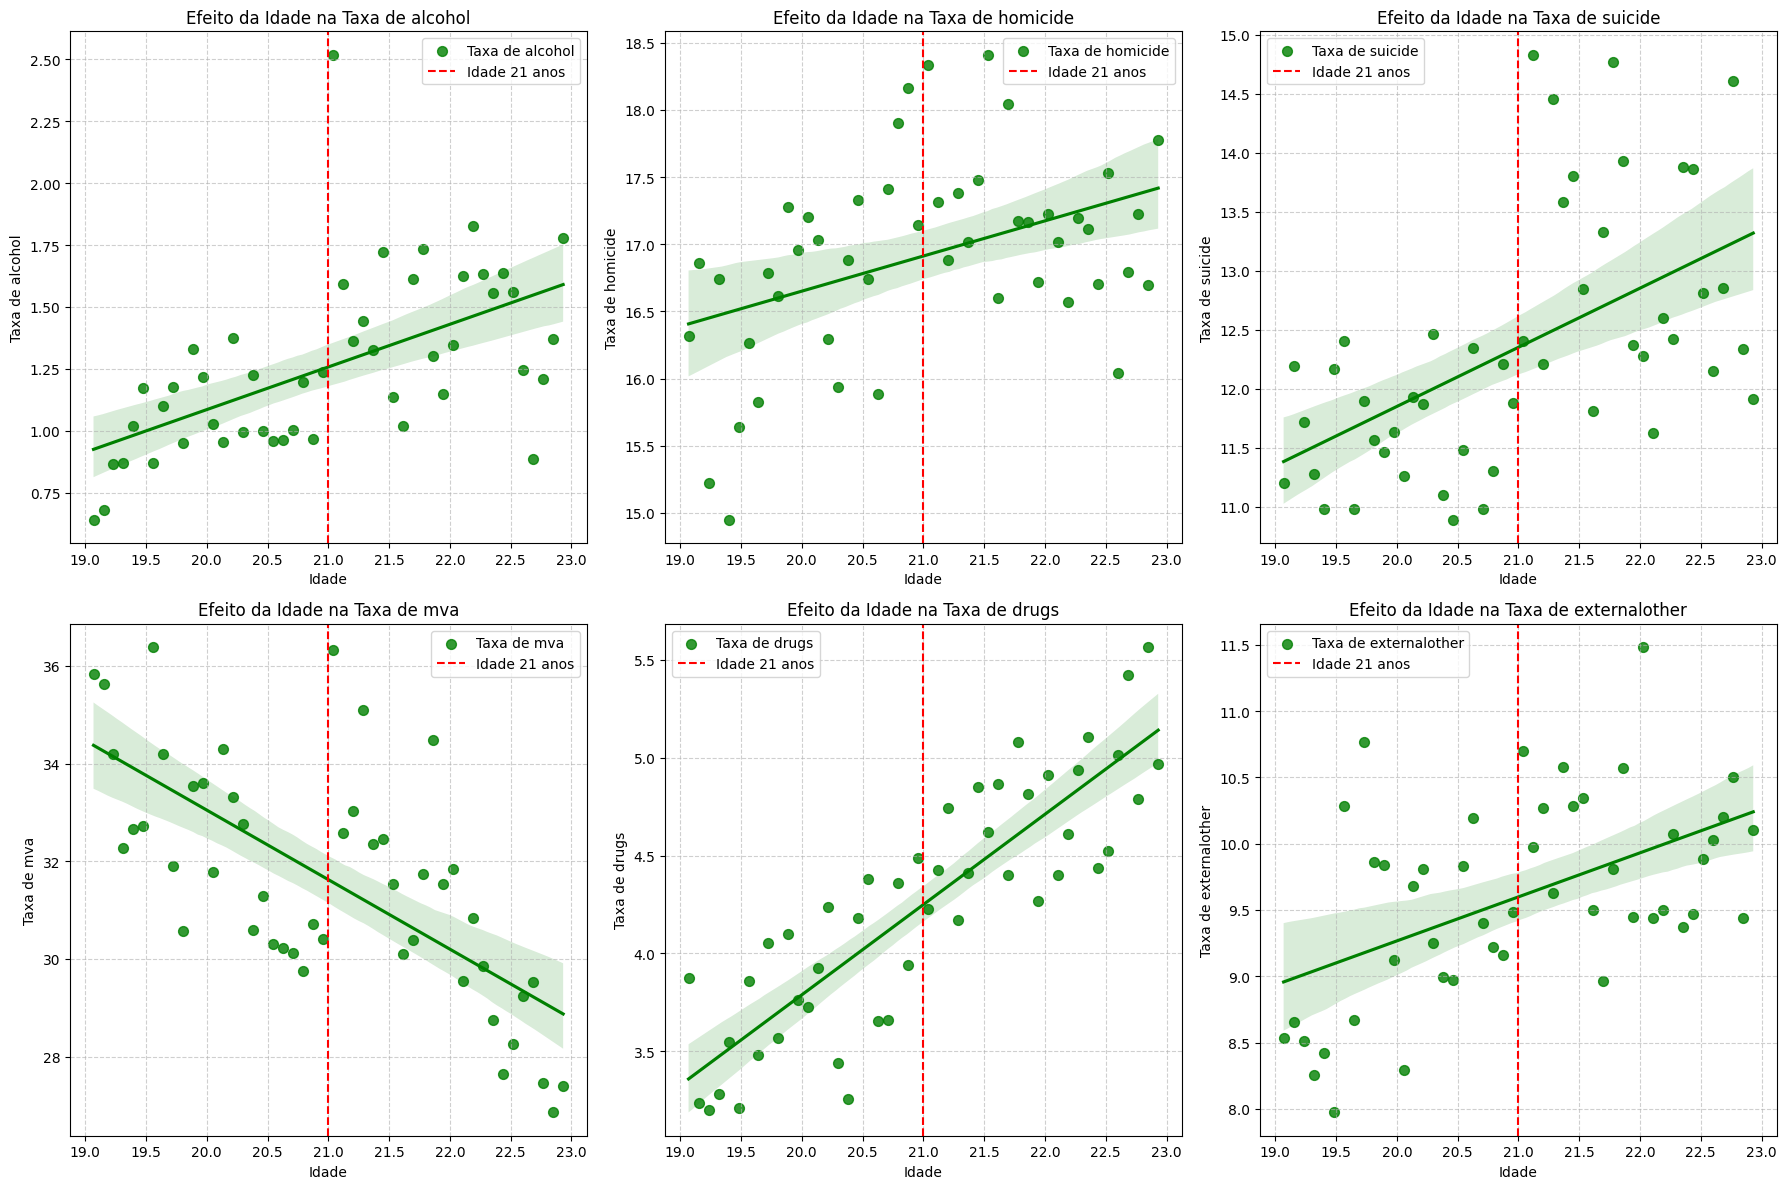

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Carregar os dados
df = pd.read_stata("AEJfigs.dta")

# Verificar as primeiras linhas dos dados
print(df.head())

# (i): Reproduzir o gráfico da Figura 3 (Taxa de mortalidade geral por idade)
plt.figure(figsize=(10, 6))
sns.regplot(x="agecell", y="all", data=df, label="Taxa de Mortalidade Geral", color="blue", scatter_kws={"s": 50})
plt.axvline(x=21, color="red", linestyle="--", label="Idade 21 anos")
plt.xlabel("Idade")
plt.ylabel("Taxa de Mortalidade Geral (all)")
plt.title("(i) Efeito da Idade na Taxa de Mortalidade Geral")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# (ii): Regressão Descontínua para a variável 'all' (taxa de mortalidade geral)
# Criar variável de tratamento (1 se idade >= 21, 0 caso contrário)
df["treatment"] = (df["agecell"] >= 21).astype(int)

# Centralizar a idade em torno de 21 anos
df["age_centered"] = df["agecell"] - 21

# Modelo de regressão descontínua
model = smf.ols("all ~ treatment + age_centered + treatment:age_centered", data=df).fit()

# Exibir resultados da regressão
print("Questão (ii): Regressão Descontínua para 'all'")
print(model.summary())

# (iii): Gráficos para todas as variáveis de mortalidade por idade
# Lista de variáveis de mortalidade
variables = ["alcohol", "homicide", "suicide", "mva", "drugs", "externalother"]

# Criar subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Loop para criar gráficos para cada variável
for i, var in enumerate(variables):
    sns.regplot(x="agecell", y=var, data=df, ax=axes[i], label=f"Taxa de {var}", color="green", scatter_kws={"s": 50})
    axes[i].axvline(x=21, color="red", linestyle="--", label="Idade 21 anos")
    axes[i].set_xlabel("Idade")
    axes[i].set_ylabel(f"Taxa de {var}")
    axes[i].set_title(f"Efeito da Idade na Taxa de {var}")
    axes[i].legend()
    axes[i].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

### (i): Efeito da Idade na Taxa de Mortalidade Geral

O gráfico mostra a relação entre a idade (`agecell`) e a taxa de mortalidade geral (`all`). A linha vertical em 21 anos destaca a descontinuidade, que é o ponto onde a idade legal para consumo de álcool muda. O gráfico indica que há um aumento na taxa de mortalidade geral após os 21 anos, sugerindo que o consumo de álcool pode ter um impacto significativo na mortalidade.

### (ii): Regressão Descontínua para 'all'

Os resultados da regressão descontínua para a taxa de mortalidade geral (`all`) são os seguintes:

- **R-quadrado**: 0.668, indicando que o modelo explica 66,8% da variabilidade na taxa de mortalidade geral.
- **Coeficiente de `treatment`**: 7.6627, com um p-valor de 0.000, indicando que o tratamento (idade ≥ 21 anos) tem um efeito estatisticamente significativo na taxa de mortalidade geral. Isso sugere que o consumo de álcool aumenta a taxa de mortalidade geral.
- **Coeficiente de `age_centered`**: 0.8270, com um p-valor de 0.318, indicando que a idade em si não tem um efeito significativo na taxa de mortalidade geral quando considerada isoladamente.
- **Coeficiente de `treatment:age_centered`**: -3.6034, com um p-valor de 0.003, indicando que a interação entre o tratamento e a idade é significativa. Isso sugere que o efeito do tratamento varia com a idade.

### (iii): Efeito da Idade nas Taxas de Mortalidade por Diferentes Causas

Os gráficos mostram a relação entre a idade e as taxas de mortalidade para diferentes causas (`alcohol`, `homicide`, `suicide`, `mva`, `drugs`, `externalother`). Cada gráfico inclui uma linha de regressão linear e uma linha vertical em 21 anos para destacar a descontinuidade.

- **Taxa de `alcohol`**: Mostra um aumento significativo após os 21 anos, indicando que o consumo de álcool está diretamente relacionado a um aumento na mortalidade por causas relacionadas ao álcool.
- **Taxa de `homicide`**: Também mostra um aumento após os 21 anos, sugerindo que o consumo de álcool pode estar relacionado a um aumento na mortalidade por homicídios.
- **Taxa de `suicide`**: O aumento após os 21 anos é menos pronunciado, mas ainda sugere uma possível relação entre o consumo de álcool e a mortalidade por suicídio.
- **Taxa de `mva`**: Mostra um aumento significativo após os 21 anos, indicando que o consumo de álcool está relacionado a um aumento na mortalidade por acidentes de carro.
- **Taxa de `drugs`**: O aumento após os 21 anos é menos claro, sugerindo que o consumo de álcool pode não ter um impacto significativo na mortalidade por causas relacionadas a drogas.
- **Taxa de `externalother`**: Mostra um aumento moderado após os 21 anos, indicando que o consumo de álcool pode estar relacionado a um aumento na mortalidade por outras causas externas.